### 导入依赖

In [2]:
import pickle
import pandas as pd
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, mean_squared_error
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

### 读取数据

In [3]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'output/gene_editing/result.array'
transplant_arr_path = r'output/transplant/result.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)


### 模型评估方法
MAE，MSE，RMSE，MAPE（逐年和全部平均）

precision，recall，F1，accuracy（分类，逐年和全部平均）

NDCG@20（新兴主题发现）

In [4]:
def cal_ndcg(n, true, pred):
    _true = true.reshape(-1)
    _pred = pred.reshape(-1)
    
    _list = list(zip(_true, _pred))
    true_list = sorted(_list, key=lambda x: x[0], reverse=True)[:n]
    pred_list = sorted(_list, key=lambda x: x[1], reverse=True)[:n]
    
    true_array = np.zeros((len(true_list), 2))
    pred_array = np.zeros((len(pred_list), 2))
    
    for i, num in enumerate(true_list):
        true_array[i] = np.array([i+1, num[0]])
    
    for i, num in enumerate(pred_list):
        pred_array[i] = np.array([i+1, num[0]])
    
    # 使用工业界的算法
#     ideal_score = np.sum((2 ** true_array[:, 1] - 1) / np.log2(true_array[:, 0] + 1))
#     pred_score = np.sum((2 ** pred_array[:, 1] - 1) / np.log2(pred_array[:, 0] + 1))
    ideal_score = np.sum((true_array[:, 1]) / np.log2(true_array[:, 0] + 1))
    pred_score = np.sum((pred_array[:, 1]) / np.log2(pred_array[:, 0] + 1))
    
    return pred_score / ideal_score
    
    
    
def eval_model(method, y_true, y_pred):
    if method.lower() == 'mae':
        errors = np.abs(y_true - y_pred)
        annual_mae = np.mean(errors, axis=0)
        overall_mae = np.mean(errors, axis=None)
        
        return overall_mae, annual_mae
    
    if method.lower() == 'mse':
        errors = np.square(y_true - y_pred)
        annual_mse = np.mean(errors, axis=0)
        overall_mse = np.mean(errors, axis=None)
        
        return overall_mse, annual_mse
    
    if method.lower() == 'rmse':
        errors = np.square(y_true - y_pred)
        annual_rmse = np.sqrt(np.mean(errors, axis=0))
        overall_rmse = np.sqrt(np.mean(errors, axis=None))
        
        return overall_rmse, annual_rmse
    
    if method.lower() == 'mape':
        errors = np.abs((y_true - y_pred) / y_true)
        annual_mape = np.mean(errors, axis=0)
        overall_mape = np.mean(errors, axis=None)
    
        return overall_mape, annual_mape
    
    if method.lower() == 'ndcg':
        n = 20
        samples, years = y_true.shape
        annual_ndcg = []
        
        for year in range(years):
            annual_ndcg.append(cal_ndcg(n, y_true[:, year], y_pred[:, year]))
        
        overall_ndcg = cal_ndcg(n, np.sum(y_true, axis=1), np.sum(y_pred, axis=1))
        
        return overall_ndcg, annual_ndcg
    
    if method.lower() == 'classification':
        percentiles = [70, 85, 95]
        
        

In [5]:
cal_ndcg(10, np.array([10, 9, 8, 7, 6, 5, 4, 3, 2, 1]), np.array(list(range(10))))

0.6678559202923124

### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [6]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 数据规范化
为了提升效果，先进行规范化再作训练集和测试集的划分（暴露了一点测试集信息）

因为原来的数据是三维数组，所以需要转成二维再规范化（这里选择了转成term * timestep, features的维度，也可以试一下term, timestep * features的维度）

使用了两种Scaler来尝试

In [7]:
reshaped_gene_arr = gene_arr.reshape(gene_arr.shape[0] * gene_arr.shape[1], gene_arr.shape[2])
reshaped_transplant_arr = transplant_arr.reshape(transplant_arr.shape[0] * transplant_arr.shape[1], transplant_arr.shape[2])

# reshaped_gene_arr = gene_arr.reshape(gene_arr.shape[0], gene_arr.shape[1] * gene_arr.shape[2])
# reshaped_transplant_arr = transplant_arr.reshape(transplant_arr.shape[0], transplant_arr.shape[1] * transplant_arr.shape[2])

# StandardScaler
g_sscaler = StandardScaler()
t_sscaler = StandardScaler()
gene_arr_sscaled = g_sscaler.fit_transform(reshaped_gene_arr).reshape(gene_arr.shape)
transplant_arr_sscaled = t_sscaler.fit_transform(reshaped_transplant_arr).reshape(transplant_arr.shape)

# MinMaxScaler
g_mscaler = MinMaxScaler()
t_mscaler = MinMaxScaler()
gene_arr_mscaled = g_mscaler.fit_transform(reshaped_gene_arr).reshape(gene_arr.shape)
transplant_arr_mscaled = t_mscaler.fit_transform(reshaped_transplant_arr).reshape(transplant_arr.shape)

### 划分训练集和测试集
测试集比例也会影响“效果”

In [8]:
# 获取回归任务数据
def get_regression_train_test(data, n_input, scaler, ratio):
    if data == 'gene':
        arr = gene_arr
        arr_sscaled = gene_arr_sscaled
        arr_mscaled = gene_arr_mscaled
    elif data == 'transplant':
        arr = transplant_arr
        arr_sscaled = transplant_arr_sscaled
        arr_mscaled = transplant_arr_mscaled
    else:
        print('error')
    
    if scaler == 'none':
        X, y = arr[:, :n_input, :], arr[:, n_input:, -2]
    elif scaler == 'standard':
        X, y = arr_sscaled[:, :n_input, :], arr_sscaled[:, n_input:, -2]
    elif scaler == 'minmax':
        X, y = arr_mscaled[:, :n_input, :], arr_mscaled[:, n_input:, -2]
    
    return train_test_split(X, y, test_size=ratio, random_state=20200214, shuffle=True)

# 获取分类任务数据
def get_classification_train_test(data, n_input, scaler, ratio):
    if data == 'gene':
        arr = gene_arr
        arr_label = gene_arr
        arr_sscaled = gene_arr_sscaled
        arr_mscaled = gene_arr_mscaled
    elif data == 'transplant':
        arr = transplant_arr
        arr_label = transplant_arr
        arr_sscaled = transplant_arr_sscaled
        arr_mscaled = transplant_arr_mscaled
    else:
        print('error')
    
    if scaler == 'none':
        X, y = arr[:, :n_input, :], arr_label[:, n_input:, -1].astype(int)
    elif scaler == 'standard':
        X, y = arr_sscaled[:, :n_input, :], arr_label[:, n_input:, -1].astype(int)
    elif scaler == 'minmax':
        X, y = arr_mscaled[:, :n_input, :], arr_label[:, n_input:, -1].astype(int)
#     print(X.shape, y.shape)
    
    return train_test_split(X, y, test_size=ratio, random_state=20200214, shuffle=True)

### 构建Endocer-Decoder模型（无teacher forcing）

In [9]:
def build_encoder_decoder_model(classification=False):
    model = keras.models.Sequential()
    model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(256, activation='tanh'))
    model.add(RepeatVector(y_train.shape[1]))
    model.add(LSTM(256, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(128, activation='relu')))
    
    if classification:
        model.add(TimeDistributed(Dense(5, activation='softmax')))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
    else: 
        model.add(TimeDistributed(Dense(1)))
        model.compile(loss='mae', optimizer='adam')
    return model

### 构建Encoder-Decoder模型（有teacher forcing）

In [10]:
def build_tf_encoder_decoder_model():
    n_input = 11
    n_units = 256
    n_output = 1
    
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation=None)
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    
    model.compile(optimizer='adam', loss='mae')
    
    # return all models
    return model, encoder_model, decoder_model


def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return np.array(output)

In [11]:
X_train, X_test, y_train, y_test = get_regression_train_test('transplant', 11, 'standard', 0.2)

In [468]:
decoder_in_training = np.roll(y_train, 1, axis=1)
decoder_in_training[:, 0] = 0.0
decoder_in_training = decoder_in_training.reshape(len(decoder_in_training), -1, 1)

decoder_in_validation = np.roll(y_test, 1, axis=1)
decoder_in_validation[:, 0] = 0.0
decoder_in_validation = decoder_in_validation.reshape(len(decoder_in_validation), -1, 1)

model, encoder_model, decoder_model = build_tf_encoder_decoder_model()

In [469]:
history = model.fit([X_train, decoder_in_training], y_train, 
                    epochs=1000, validation_data=([X_test, decoder_in_validation], y_test),
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      min_delta=0, 
                                                                      patience=20, 
                                                                      verbose=0, 
                                                                      mode='auto', 
                                                                      baseline=None, 
                                                                      restore_best_weights=False)])

Train on 4112 samples, validate on 1029 samples
Epoch 1/1000
4112/4112 [==============================] - 13s 3ms/sample - loss: 0.5237 - val_loss: 0.5240
Epoch 2/1000
4112/4112 [==============================] - 5s 1ms/sample - loss: 0.5101 - val_loss: 0.5240
Epoch 3/1000
4112/4112 [==============================] - 5s 1ms/sample - loss: 0.5074 - val_loss: 0.5206
Epoch 4/1000
4112/4112 [==============================] - 5s 1ms/sample - loss: 0.5046 - val_loss: 0.5157
Epoch 5/1000
4112/4112 [==============================] - 5s 1ms/sample - loss: 0.5014 - val_loss: 0.5120
Epoch 6/1000
4112/4112 [==============================] - 5s 1ms/sample - loss: 0.4988 - val_loss: 0.5126
Epoch 7/1000
4112/4112 [==============================] - 5s 1ms/sample - loss: 0.4976 - val_loss: 0.5131
Epoch 8/1000
4112/4112 [==============================] - 6s 1ms/sample - loss: 0.4959 - val_loss: 0.5139
Epoch 9/1000
4112/4112 [==============================] - 6s 1ms/sample - loss: 0.4957 - val_loss: 0.51

In [470]:
y_pred = list()
for i in X_test:
    y_pred.append(predict_sequence(encoder_model, decoder_model, np.expand_dims(i, axis=0), len(y_test[0]), 1))
y_pred = np.array(y_pred).reshape(y_test.shape)

### 构建普通RNN模型

In [12]:
def build_basic_rnn_model(classification=False):
    model = keras.models.Sequential()
    model.add(LSTM(256, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(256, activation='tanh'))
    model.add(Dense(128, activation='relu'))
    
    if classification:
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    else: 
#         model.add(Dense(y_train.shape[1]))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
    return model

### 构建前馈神经网络模型

In [13]:
def build_dnn_model(classification=False):
    model = keras.models.Sequential()
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    
    if classification:
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    else: 
        model.add(Dense(y_train.shape[1]))
        model.compile(loss='mae', optimizer='adam')
    return model

### 构建Persistence Model
简单将前一个时间点的预测作为下一个时间点的预测

In [31]:
def persistence_model_predict(X, y):
    es_x = X[:, -1, -2].reshape(len(X), 1)
    es_y = y[:, :-1]
    return np.hstack((es_x, es_y))

### 为每一时间点的预测单独构建模型

In [65]:
def get_seperate_models(model, X_train, y_train, X_test, y_test):
    y_train_list = []
    y_test_list = []
    models = []
    for i in range(len(y_train[0])):
        y_train_list.append(y_train[:, i])
        y_test_list.append(y_test[:, i])
    
    for y, y2 in zip(y_train_list, y_test_list):
        _model = clone_model(model)
        _model.compile(loss='mae', optimizer='adam')
        _model.fit(X_train, y, epochs=1000, batch_size=16, verbose=1, validation_data=(X_test, y2), 
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      min_delta=0, 
                                                                      patience=3, 
                                                                      verbose=0, 
                                                                      mode='auto', 
                                                                      baseline=None, 
                                                                      restore_best_weights=False)])
        models.append(_model)
    return models
    

In [497]:
model = build_encoder_decoder_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_test, y_test), 
                   callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                      min_delta=0, 
                                                                      patience=20, 
                                                                      verbose=0, 
                                                                      mode='auto', 
                                                                      baseline=None, 
                                                                      restore_best_weights=False)])

Train on 4112 samples, validate on 1029 samples
Epoch 1/100
4112/4112 [==============================] - 26s 6ms/sample - loss: 0.5267 - val_loss: 0.5339
Epoch 2/100
4112/4112 [==============================] - 18s 4ms/sample - loss: 0.5122 - val_loss: 0.5338
Epoch 3/100
4112/4112 [==============================] - 19s 5ms/sample - loss: 0.5098 - val_loss: 0.5222
Epoch 4/100
4112/4112 [==============================] - 19s 5ms/sample - loss: 0.5101 - val_loss: 0.5283
Epoch 5/100
4112/4112 [==============================] - 19s 5ms/sample - loss: 0.5080 - val_loss: 0.5235
Epoch 6/100
4112/4112 [==============================] - 19s 5ms/sample - loss: 0.5079 - val_loss: 0.5206
Epoch 7/100
4112/4112 [==============================] - 19s 5ms/sample - loss: 0.5066 - val_loss: 0.5191
Epoch 8/100
4112/4112 [==============================] - 19s 5ms/sample - loss: 0.5057 - val_loss: 0.5201
Epoch 9/100
4112/4112 [==============================] - 19s 5ms/sample - loss: 0.5051 - val_loss: 0.522

In [498]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [32]:
test_pred = persistence_model_predict(X_test, y_test)

0.8041005069181192
[0.85690921 0.83270667 0.82931539 0.76622155 0.73534971]


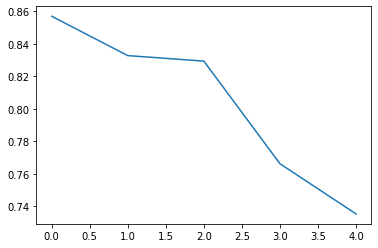

In [43]:
overall, annual = eval_model('mae', y_test, test_pred.reshape(y_test.shape))
print(overall)
print(annual)
plt.plot(annual)
plt.show()

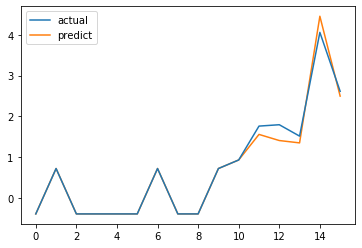

In [25]:
i = 11
plt.plot(np.concatenate((X_train[i, :, -2], y_train[i].reshape(-1)), axis=None), label='actual', zorder=1)
plt.plot(np.concatenate((X_train[i, :, -2], train_pred[i].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.show()

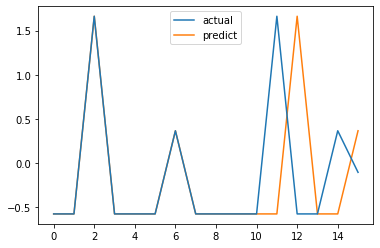

In [40]:
i = 13
plt.plot(np.concatenate((X_test[i, :, -2], y_test[i].reshape(-1)), axis=None), label='actual', zorder=1)
plt.plot(np.concatenate((X_test[i, :, -2], test_pred[i].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.show()

### 将数值转换回去前需要确保是（N, 11）的形状

In [284]:
g_sscaler.inverse_transform(X_train[97])

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 4.00000000e+00, 4.00000000e+00, 4.00000000e+01,
        0.00000000e+00, 7.00000000e+00, 1.00000000e+01, 3.00000000e+00,
        7.37000000e+02, 1.38629436e+00, 4.00000000e+00],
       [2.00000000e+00, 6.00000000e+00, 7.10000000e+01, 1.59000000e+02,
        0.00000000e+00, 0.00000000e+00, 2.00000000e+01, 2.00000000e+00,
        1.29500000e+03, 1.64791843e+00, 4.00000000e+00],
       [5.00000000e+00, 1.00000000e+01, 2.10000000e+01, 1.77000000e+02,
        0.00000000e+00, 5.00000000e+00, 3.40000000e+01, 6.00000000e+00,
        3.16100000e+03, 3.58351894e+00, 4.00000000e+